# Project: How do Movie Metrics affects its viewer rating on iMDB?

## Table of Contents:
* [Introduction](#1)
* [Wrangling](#2)
* [Exploratory Visuals](#3)
* [Explanatory Visuals](#4)
* [Conclusion](#5)

## Introduction:<a class="anchor" id="1"></a>
Have you ever browsed iMDB looking for good movies to watch, sorted by rating? Or browsing the movie you just watched on iMDB, only to find that it has a shockingly low or high viewer rating? What can we say about the high or low ratings of a movie on iMDB?

We take a dive into the dataset provided by Kaggle (but now replaced with TMDB ratings due to DMCA Takedown https://www.kaggle.com/tmdb/tmdb-movie-metadata/home) to see what's going on behind these scores!

In [40]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

In [2]:
# read in .csv
df_og = pd.read_csv('imdb-movies.csv')

## Wrangling:<a class="anchor" id="2"></a>

In [3]:
# Create a copy to work on for wrangling + rest of the analysis
df = df_og.copy()

In [4]:
# Let us take a look at the shape of the dataset
df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [5]:
df.shape

(10866, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [7]:
# Let's drop columns we aren't concerened with for this analysis
df.drop(['id', 'imdb_id', 'budget', 'revenue', 'cast', 'homepage', 'director', 'tagline', 'keywords', 
         'overview', 'production_companies'], axis = 1, inplace = True)

In [8]:
# How many movies in the dataset have more than 100 votes?
df.query('vote_count > 100').count()

popularity        3309
original_title    3309
runtime           3309
genres            3309
release_date      3309
vote_count        3309
vote_average      3309
release_year      3309
budget_adj        3309
revenue_adj       3309
dtype: int64

In [9]:
# We want to analyze movies that have at least 100 votes for its score
df = df[df.vote_count > 100]

In [10]:
# In this data, missing data in budget_adj and revenue_adj are represented with 0, instead of NA, let's get rid of those rows
df = df[df.budget_adj != 0]
df = df[df.revenue_adj != 0]

In [11]:
type(df.release_date[0])

str

In [12]:
# Let's convert release date to datetime object
df.release_date = pd.to_datetime(df.release_date)

In [13]:
# Let's convert genres into number of genres a movie encompasses by counting the separator "|" then adding 1
split_columns = ['genres']

for c in split_columns:
    df[c] = df[c].str.count('\|') + 1

In [14]:
# Rename and convert type to int
df.rename(columns = {'genres' : 'n_genres'}, inplace = True)
df.n_genres = df.n_genres.astype('int')

In [15]:
# Drop duplicated rows and any rows with missing information
df.drop_duplicates(inplace = True)
df.dropna(inplace = True)

In [16]:
# We are now ready for analysis
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2603 entries, 0 to 10770
Data columns (total 10 columns):
popularity        2603 non-null float64
original_title    2603 non-null object
runtime           2603 non-null int64
n_genres          2603 non-null int32
release_date      2603 non-null datetime64[ns]
vote_count        2603 non-null int64
vote_average      2603 non-null float64
release_year      2603 non-null int64
budget_adj        2603 non-null float64
revenue_adj       2603 non-null float64
dtypes: datetime64[ns](1), float64(4), int32(1), int64(3), object(1)
memory usage: 213.5+ KB


## Exploratory Visuals:<a class="anchor" id="3"></a>

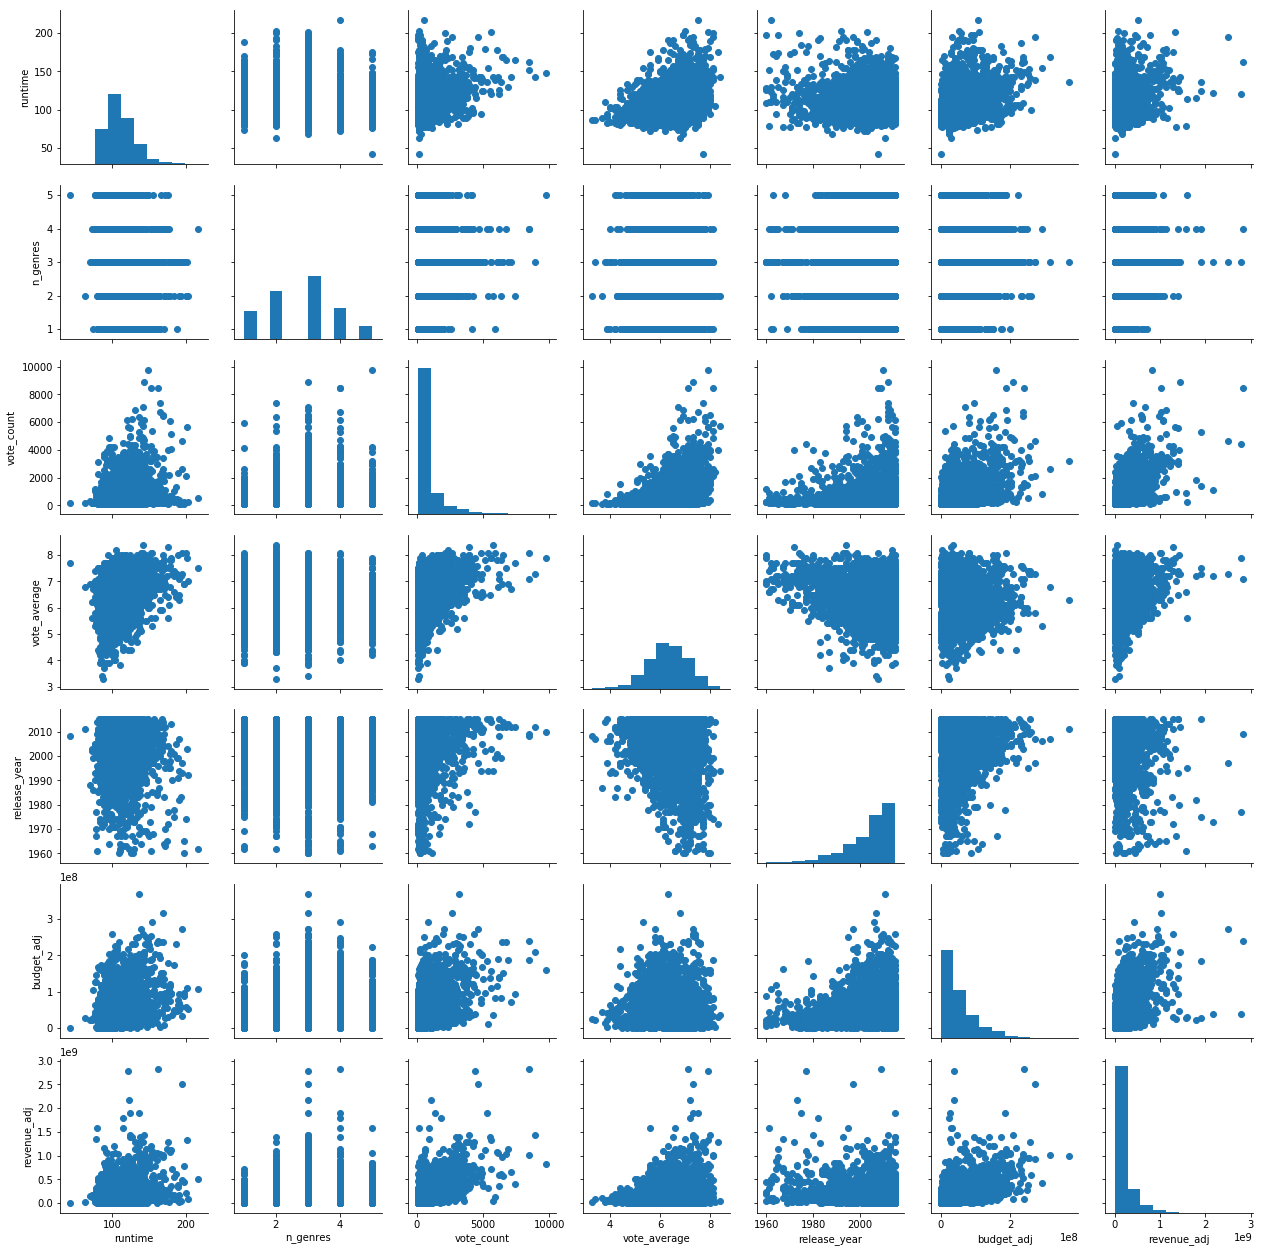

In [18]:
columns = ['runtime', 'n_genres', 'vote_count', 'vote_average', 'release_year', 'budget_adj', 'revenue_adj']
g = sb.PairGrid(data = df, vars = columns)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

## Explanatory Visuals: <a class="anchor" id="4"></a>

### Distribution of Viewer Rating

6.316980407222439

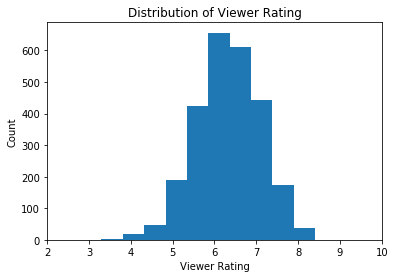

In [23]:
plt.hist(data = df, x = 'vote_average')
plt.title('Distribution of Viewer Rating')
plt.xlabel('Viewer Rating')
plt.ylabel('Count')
plt.xlim(2,10);

df.vote_average.mean()

Looks like our viewer rating resembles a normal distribution with a mean centered at approximately 6.32 (score out of 10)

### Viewer Rating vs Movie Budget

array([[ 1.     , -0.03816],
       [-0.03816,  1.     ]])

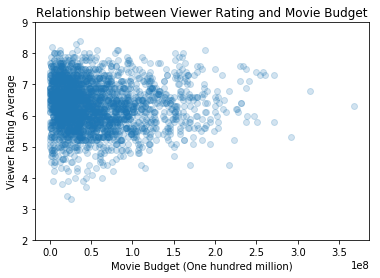

In [24]:
x = df.budget_adj
y = df.vote_average
plt.scatter(data = df, x = 'budget_adj', y = 'vote_average', alpha = 0.2)
plt.ylim(2,9)
plt.title('Relationship between Viewer Rating and Movie Budget');
plt.xlabel('Movie Budget (One hundred million)');
plt.ylabel('Viewer Rating Average');
np.corrcoef(x, y)

It's easy to assume that if more budget is spent on the movie, it would generate higher ratings due to better cast, editing technology, set, etc. However, there seems to be absolutely no relationship here. Let's take a look at revenue generated next.

### Viewer Rating vs Movie Revenue

array([[1.        , 0.23118244],
       [0.23118244, 1.        ]])

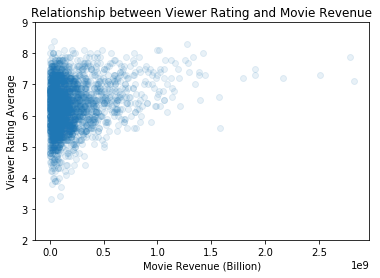

In [23]:
x = df.revenue_adj
y = df.vote_average
plt.scatter(data = df, x = 'revenue_adj', y = 'vote_average', alpha = 0.1)
plt.ylim(2,9)
plt.title('Relationship between Viewer Rating and Movie Revenue');
plt.xlabel('Movie Revenue (Billion)');
plt.ylabel('Viewer Rating Average');
np.corrcoef(x, y)

Movie revenue almost directly speaks for the success of a film. This however, may not mean that the kind of people who review movies on iMDB have enjoyed it. This is reflected in the rather weak positive correlation of 0.231 between Movie Revenue and Viewer Score.

### Viewer Rating vs Release Year

array([[1.        , 0.23118244],
       [0.23118244, 1.        ]])

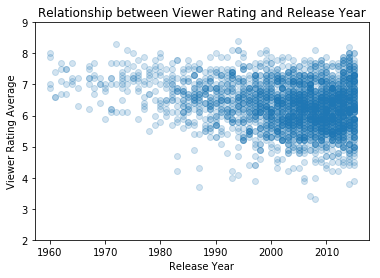

In [22]:
x = df.revenue_adj
y = df.vote_average
plt.scatter(data = df, x = 'release_year', y = 'vote_average', alpha = 0.2)
plt.ylim(2,9)
plt.title('Relationship between Viewer Rating and Release Year');
plt.xlabel('Release Year');
plt.ylabel('Viewer Rating Average');
np.corrcoef(x, y)

We find ourselves a weak positive correltion (0.231) here between Viewer Rating and Movie Release Year. This may have been caused by the fact that there are more samples of recent movies (after 1990) as compared to older movies (before 1990)

### Viewer Rating vs Vote Count

array([[1.        , 0.39554545],
       [0.39554545, 1.        ]])

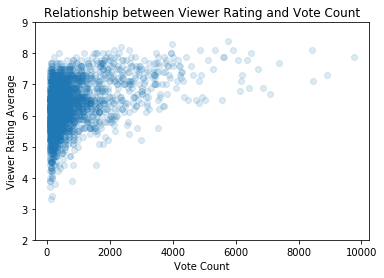

In [21]:
x = df.vote_count
y = df.vote_average
plt.scatter(data = df, x = 'vote_count', y = 'vote_average', alpha = 0.15)
plt.ylim(2,9)
plt.title('Relationship between Viewer Rating and Vote Count');
plt.xlabel('Vote Count');
plt.ylabel('Viewer Rating Average');
np.corrcoef(x, y)

And we've finally found ourselves a moderate positive correlation (0.396) to look into! It looks like the more ratings a movie gets, the more positive it is. We can explain this in multiple ways, but I feel that the most likely explanation is that iMDB movie watchers are more likely to leave a review if they enjoyed the movie and less likely to do so if they did not enjoy it. 

Why is that?

One explanation I can come up with is that iMDB movie reviewers are not your typical movie-watchers, but they aren't professional movie critiques either. Hence, they are not entirely confident in being challenged on their negative review of a movie. I'm sure there are many other ways to explain this correlation, but I feel strongly that confrontation aversion and lack of confidence is playing a role here.

### Viewer Rating vs Number of Genres

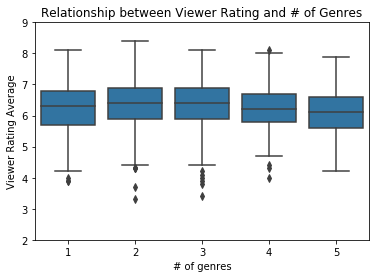

In [29]:
base_color = sb.color_palette()[0]
sb.boxplot(data = df, x = 'n_genres', y = 'vote_average', color = base_color)
plt.ylim(2,9)
plt.title('Relationship between Viewer Rating and # of Genres')
plt.ylabel('Viewer Rating Average')
plt.xlabel('# of genres');

There seems to be no significant relationship between the number of genres a movie encompasses and its viewer rating.

### Viewer Rating vs Movie Runtime

array([[1.        , 0.38187858],
       [0.38187858, 1.        ]])

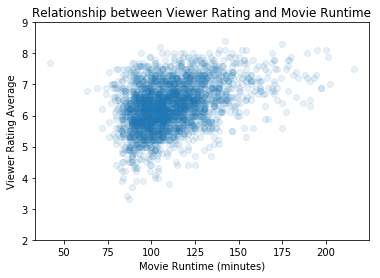

In [30]:
x = df.runtime
y = df.vote_average
plt.scatter(data = df, x = 'runtime', y = 'vote_average', alpha = 0.1)
plt.ylim(2,9)
plt.title('Relationship between Viewer Rating and Movie Runtime');
plt.xlabel('Movie Runtime (minutes)');
plt.ylabel('Viewer Rating Average');
np.corrcoef(x, y)

In [31]:
df.runtime.max()

216

We find a moderate positive correlation (0.382) between Movie Runtime and Viewer Rating, where longer movies tend to receive a more postive score by reviewers. One explanation is that shorter movies tend to feel rushed in explaining the plot of the movie and cover less plotholes, hence leaves more room for confusion and overall dissatisfaction by the end of the movie.

Another explanation, albeit in my opinion less likely, is that as movie-loving iMDB reviewer, they just really like long movies.

If there were movies in the dataset that ran over 216 minutes (That's more than 3 and a half hours!) up to maybe 500, I believe the line of best fit for the scatter graph would resemble a negative quadratic function.

### Putting Movie Runtime and Vote Count together

In [41]:
# First we will check for multicollinearity
y,X = dmatrices ('vote_average ~ budget_adj + revenue_adj + release_year + vote_count + runtime', df, return_type = 'dataframe')
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]
vif["Features"] = X.columns
vif

,VIF,Features
0,45618.156580,Intercept
1,1.593277,budget_adj
2,2.232498,revenue_adj
3,1.274584,release_year
4,1.955769,vote_count
5,1.213181,runtime


It looks like there is no multicollinearity at work among the selected columns above. Let's proceed to linear regression.

In [49]:
df['intercept'] = 1
lm = sm.OLS(df['vote_average'], df[['vote_count', 'runtime']])
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vote_average   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 4.433e+04
Date:                Fri, 08 Feb 2019   Prob (F-statistic):               0.00
Time:                        20:16:03   Log-Likelihood:                -3879.3
No. Observations:                2603   AIC:                             7763.
Df Residuals:                    2601   BIC:                             7774.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
vote_count  7.862e-05    2.2e-05      3.576      0.000    3.55e-05       0.000
runtime        0.0551      0.000    226.206      0.000       0.055       0.056
==============================================================================
Omnibus:                      146.262   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.658
Skew:                          -0.452   Prob(JB):                     9.10e-53
Kurtosis:                       4.181   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
df.vote_count.mean()

758.8459469842489

In [55]:
df.vote_count.max()

9767

97.1% of the variability in movie rating can be explained by the linear model built above.

From the results of our linear regression above, we see that both runtime and vote count's effects are statistically significant (p < 0.05). 

Every 1 extra vote amounts to an increase of 0.00007862 in the movie rating, ceteris paribus. This would mean that the movie needs 12,719 additional reviews gain exactly 1 point in a 1 to 10 rating scale. When movies are rated fiercly against one another, even 0.1 rating can make a huge difference between whether a movie makes it into iMDB's top x movies of all time, where 0.1 rating translates to about 1,272 additional reviews. When we take a look at the mean vote count of approximately 759 and max of almost 10,000, this is certainly a meaningful discovery.

We also find that every 1 minute of a movie contributes to a rating increase in 0.055, ceteris paribus. This means that every 2 minutes of a movie adds approximately 0.1 to its rating, or every 20 minutes contributing toward a rating of 1. Obviously the diminishing return is not represented in the dataset (because there exists no real movie long enough just to see this effect), but it suggests that based on our current traditional movie lengths, it plays a pretty big role in its viewer rating on iMDB.

## Conclusion: <a class="anchor" id="5"></a>

In this analysis we took a look at the effect of various movie metrics on its iMDB viewer rating. Out of budget, revenue, release year, vote count, # of genres, and runtime, only movie runtime and vote count shows moderate positive correlation with viewer rating. The strength of their effect was found through linear regression.

In the future I would like to revisit this dataset to look at the effect of nominal variables on the viewer rating, it'll be really interesting if we could find actors, actresses, and directors who are more likely to generate a higher movie rating on iMDB.